In [1]:
library(reticulate)
library(sceasy)
library(Seurat)
library(dplyr)
library(stringr)
library(tibble)
library(reshape2)
library(ggplot2)
library(ggpubr)
library(patchwork)
library(cowplot)
library(tidydr)
library(RColorBrewer)
library(ComplexHeatmap)
library(scatterpie)
library(ggcorrplot)
library(randomcoloR)
options(jupyter.plot_scale=1, repr.matrix.max.cols=200)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


The following object is masked from ‘package:ggpubr’:

    get_legend


Loading required package: grid

ComplexHeatmap version 2.22.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimen

In [2]:
update_geom_defaults("point", aes(stroke = 0))

In [3]:
b16 <- readRDS('data/b16_tc_tcr_5batch.rds')
gse <- readRDS('data/GSE178881_tcr.rds')
gse$description <- recode(gse$sample, 'D10LN'='D10-LN (Control)', 'D10SP'='D10-SP (Control)', 'D10TM'='D10-TM (Control)',
                             'D20LN'='D20-LN (Control)', 'D20SP'='D20-SP (Control)', 'D20TM'='D20-TM (Control)',
                             'D20LN_Vac'='D20-LN (Vac)', 'D20LN_aPDL1'='D20-LN (αPDL1)', 'D20LN_Combo'='D20-LN (αPDL1+Vac)',
                             'D20TM_Vac'='D20-TM (Vac)', 'D20TM_aPDL1'='D20-TM (αPDL1)', 'D20TM_Combo'='D20-TM (αPDL1+Vac)')
gse$CDsubset <- 'else'
gse$CDsubset[str_detect(gse$clusters, 'CD8')] <- 'CD8'
gse$CDsubset[str_detect(gse$clusters, 'CD4')] <- 'CD4'
b16$dataset <- 'B16F10'
gse$dataset <- 'GSE178881'
b16[["RNA"]]$scale.data <- NULL

In [4]:
merged <- merge(b16, gse)
merged <- JoinLayers(merged)
merged[["RNA"]] <- as(merged[["RNA"]], "Assay")
merged

Warning message:
“No layers found matching search pattern provided”
Warning message:
“No layers found matching search pattern provided”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Assay RNA changing from Assay5 to Assay”


An object of class Seurat 
32285 features across 110846 samples within 1 assay 
Active assay: RNA (32285 features, 2000 variable features)
 2 layers present: counts, data

In [5]:
table(merged$dataset)


   B16F10 GSE178881 
    17447     93399 

In [6]:
scvi_latent <- read.csv('data/merged_tc_scvi_emb.csv', header=F, col.names = paste0('SCVI',1:10))
rownames(scvi_latent) <- colnames(merged)
merged[["scvi"]] <- CreateDimReducObject(embeddings = as.matrix(scvi_latent), key = 'scvi_', assay='RNA')
merged <- RunUMAP(merged, dims = 1:10, reduction = "scvi", verbose=F)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [7]:
saveRDS(merged, 'data/tc_b16f10_gse178881.rds')

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”
Warning message:
“Removed 93399 rows containing missing values or values outside the scale range
(`geom_scattermore()`).”
Warning message:
“Removed 93399 rows containing missing values or values outside the scale range
(`geom_scattermore()`).”


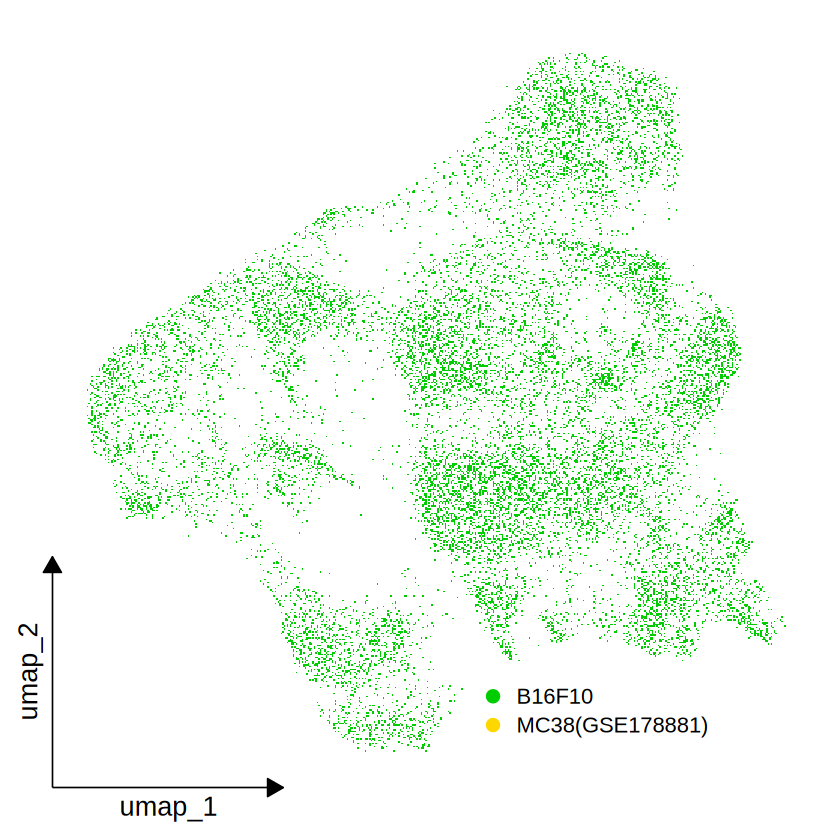

In [8]:
DimPlot(merged, reduction = "umap", group.by = "dataset", raster=T) + 
    theme_dr() + theme(legend.position=c(0.7,0.1), panel.grid=element_blank(), plot.title=element_blank(), text=element_text(size=16)) +
    scale_color_manual(values=c('green3','gold'), labels=c('B16F10','MC38(GSE178881)'))
ggsave('plot/umap_integrate_dataset.png', width=5, height=5, unit='in', dpi=500, device=png)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message:
“Removed 93399 rows containing missing values or values outside the scale range
(`geom_scattermore()`).”
Warning message:
“Removed 93399 rows containing missing values or values outside the scale range
(`geom_scattermore()`).”


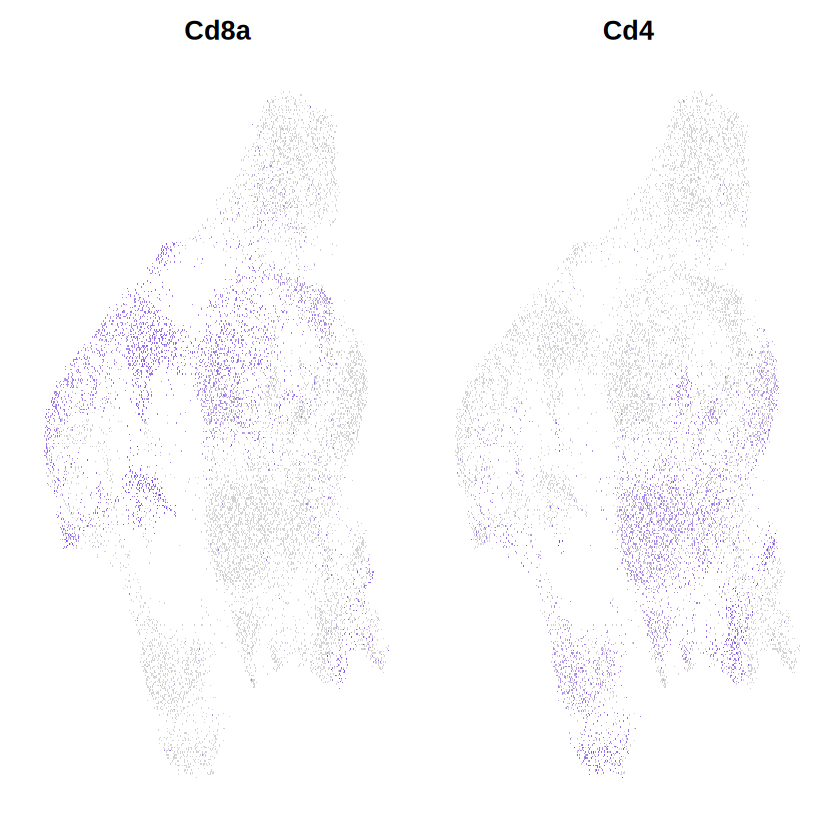

In [9]:
FeaturePlot(merged, c('Cd8a','Cd4')) & NoLegend() & NoAxes()

In [10]:
annotation_b16 <- DimPlot(merged, reduction = "umap", group.by = "annotation", label=F) + 
    scale_color_manual(values=distinctColorPalette(13), na.value="gray90", name='B16F10 annotation') + 
    theme_dr() + theme(panel.grid=element_blank(), plot.title=element_blank())
annotation_gse <- DimPlot(merged, group.by = "clusters")  +
    scale_color_manual(values=distinctColorPalette(25), na.value="gray90", name='GSE178881 annotation') + 
    theme_dr() + theme(panel.grid=element_blank(), plot.title=element_blank())

Warning message:
“Removing 93399 cells missing data for vars requested”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



DimPlot(merged, reduction = "umap", group.by = "annotation", label=F, cells.highlight = WhichCells(merged, expression= annotation=='CD4/8+ISG+')) 

Warning message:
“Removed 93399 rows containing missing values or values outside the scale range
(`geom_scattermore()`).”
Warning message:
“Removed 93399 rows containing missing values or values outside the scale range
(`geom_scattermore()`).”
Warning message:
“Removed 93399 rows containing missing values or values outside the scale range
(`geom_scattermore()`).”


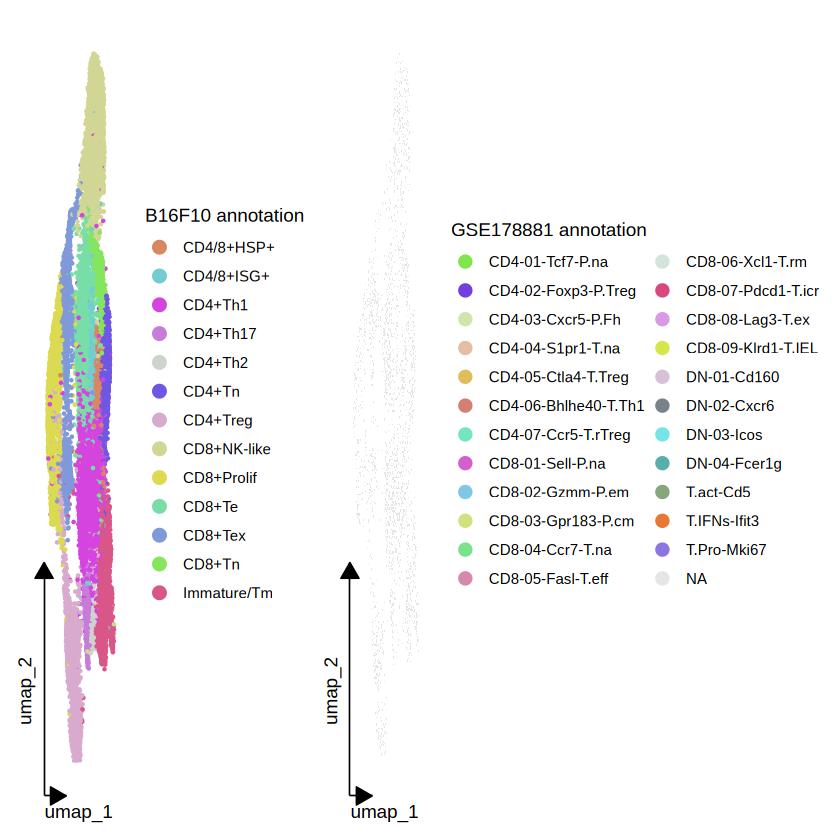

In [11]:
annotation_b16 + annotation_gse
ggsave('plot/umap_annotation_dataset.png', width=12, height=4, device=png, dpi=500)
ggsave('plot/umap_annotation_dataset.pdf', width=12, height=4, device=pdf)

In [12]:
merged$dataset_annotation <- merged$annotation
merged$dataset_annotation[is.na(merged$dataset_annotation)] <- merged$clusters[is.na(merged$dataset_annotation)]

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message:
“Removed 93399 rows containing missing values or values outside the scale range
(`geom_scattermore()`).”


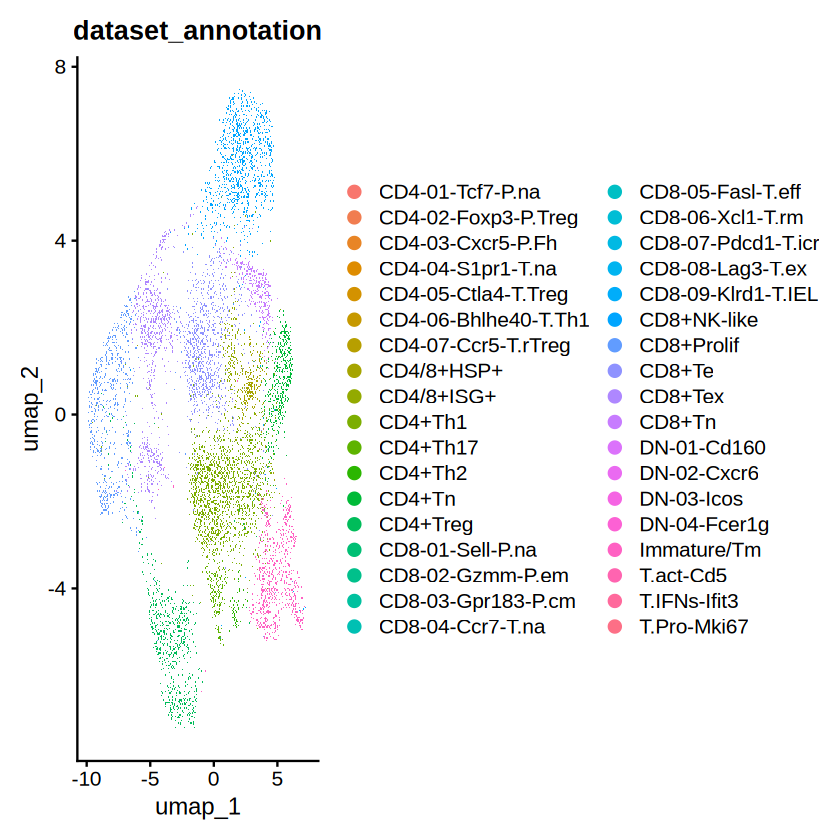

In [13]:
DimPlot(merged, reduction = "umap", group.by = "dataset_annotation")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


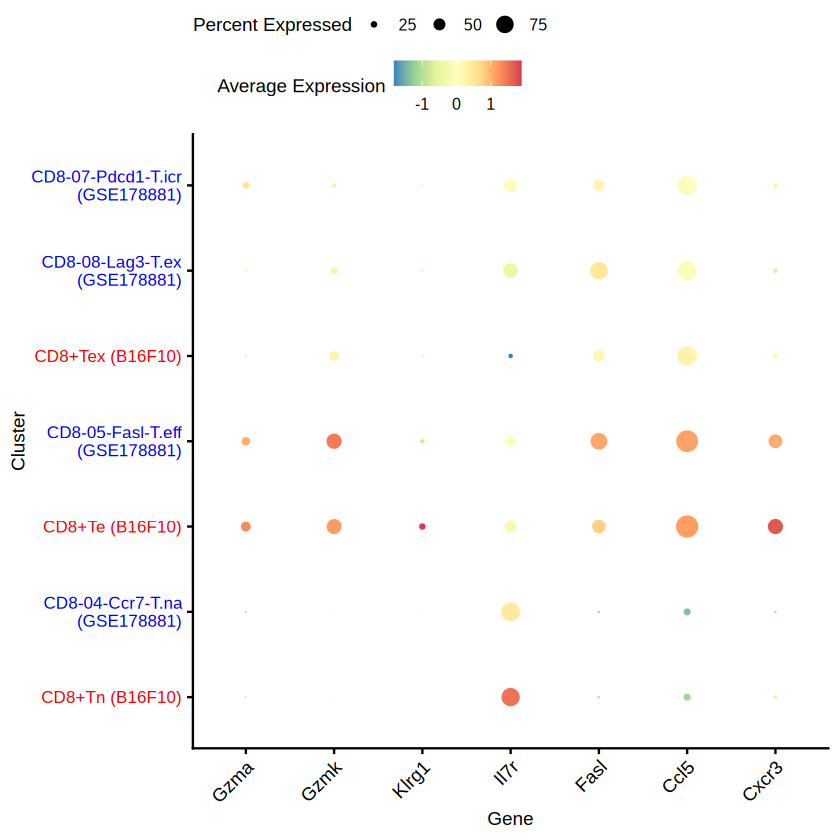

In [14]:
Idents(merged) <- 'dataset_annotation'
cd8_cluster_selected <- c('CD8+Tn','CD8-04-Ccr7-T.na','CD8+Te','CD8-05-Fasl-T.eff','CD8+Tex','CD8-08-Lag3-T.ex','CD8-07-Pdcd1-T.icr')
DotPlot(subset(merged, dataset_annotation %in% cd8_cluster_selected), 
        c('Gzma','Gzmk','Klrg1','Il7r','Fasl','Ccl5','Cxcr3'), cols = 'Spectral') +
    scale_y_discrete(limits=cd8_cluster_selected, 
                     labels=c('CD8+Tn (B16F10)','CD8-04-Ccr7-T.na\n(GSE178881)',
                              'CD8+Te (B16F10)','CD8-05-Fasl-T.eff\n(GSE178881)',
                              'CD8+Tex (B16F10)','CD8-08-Lag3-T.ex\n(GSE178881)','CD8-07-Pdcd1-T.icr\n(GSE178881)')) + labs(x='Gene', y='Cluster') +
    theme(legend.position='top', legend.box = 'vertical', text=element_text(size=11), 
          axis.text.y=element_text(color=c(rep(c('red','blue'),3), 'blue'), size=10),
          plot.background = element_rect(fill = "white",colour = NA), axis.text.x=element_text(size=11, angle=45, hjust=1, vjust=1),#
          ) 
ggsave('plot/Te_markers.pdf', width=4, height=4, device=pdf)

In [15]:
annotation_gse <- sort(unique(merged$dataset_annotation[merged$dataset=='GSE178881']))
annotation_b16 <- sort(unique(merged$dataset_annotation[merged$dataset=='B16F10']))
cor_emb <- cbind(Embeddings(merged, 'scvi'), merged@meta.data[,'dataset_annotation', drop = F]) %>% 
    split(.$dataset_annotation) %>% lapply(function(x) colMeans(x[,1:10])) %>% bind_rows(.id = 'dataset_annotation') %>% 
    column_to_rownames('dataset_annotation') %>% t() %>% cor()
merged <- FindVariableFeatures(merged)
merged <- ScaleData(merged)
cor_exp <- data.frame(t(merged[['RNA']]@scale.data))  %>% 
    split(merged$dataset_annotation) %>% lapply(colMeans) %>% bind_rows(.id = 'dataset_annotation') %>% 
    column_to_rownames('dataset_annotation') %>% t() %>% cor()

Centering and scaling data matrix



corrplot(cor_emb[annotation_gse,annotation_b16], method = 'circle')

Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


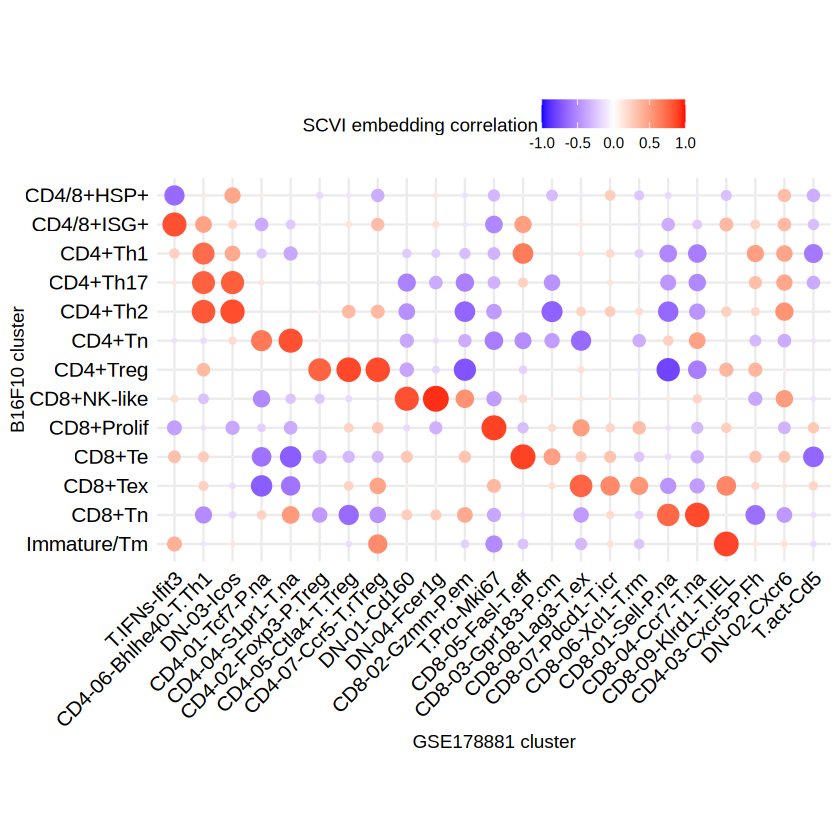

In [16]:
order_gse <- c('T.IFNs-Ifit3','CD4-06-Bhlhe40-T.Th1','DN-03-Icos','CD4-01-Tcf7-P.na','CD4-04-S1pr1-T.na','CD4-02-Foxp3-P.Treg',
              'CD4-05-Ctla4-T.Treg','CD4-07-Ccr5-T.rTreg','DN-01-Cd160','DN-04-Fcer1g','CD8-02-Gzmm-P.em','T.Pro-Mki67','CD8-05-Fasl-T.eff',
              'CD8-03-Gpr183-P.cm','CD8-08-Lag3-T.ex','CD8-07-Pdcd1-T.icr','CD8-06-Xcl1-T.rm','CD8-01-Sell-P.na','CD8-04-Ccr7-T.na',
              'CD8-09-Klrd1-T.IEL','CD4-03-Cxcr5-P.Fh','DN-02-Cxcr6','T.act-Cd5')
ggcorrplot(cor_emb[order_gse,rev(annotation_b16)], method = 'circle', legend.title='SCVI embedding correlation ') + 
    scale_size(range=c(-2,7)) + labs(x='GSE178881 cluster', y='B16F10 cluster') + 
    theme(axis.title.x = element_text(), axis.title.y = element_text(angle=90), legend.position='top', axis.text=element_text(color='black'))
ggsave('plot/cor_scvi_emb.pdf', width=7, height=5, device=pdf)

Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


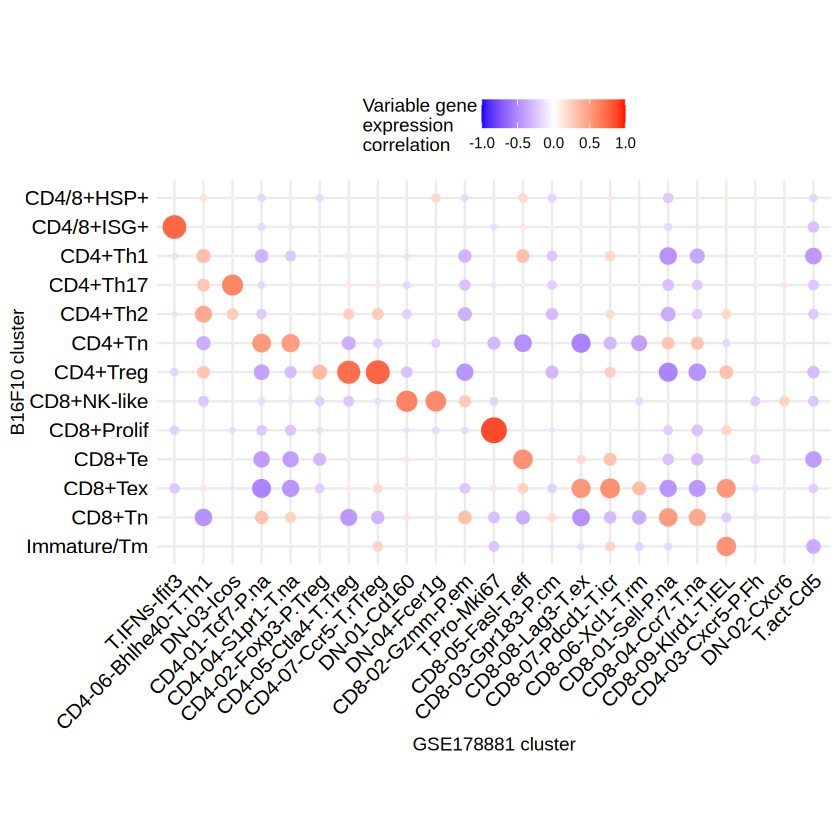

In [17]:
ggcorrplot(cor_exp[order_gse,rev(annotation_b16)], method = 'circle', legend.title='Variable gene\nexpression\ncorrelation') + 
    scale_size(range=c(-2,7)) + labs(x='GSE178881 cluster', y='B16F10 cluster') + 
    theme(axis.title.x = element_text(), axis.title.y = element_text(angle=90), legend.position='top', axis.text=element_text(color='black'))
ggsave('plot/cor_hvg_exp.pdf', width=7, height=5, device=pdf)

# Compare cell proportion

`summarise()` has grouped output by 'treatment'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'treatment'. You can override using the
`.groups` argument.


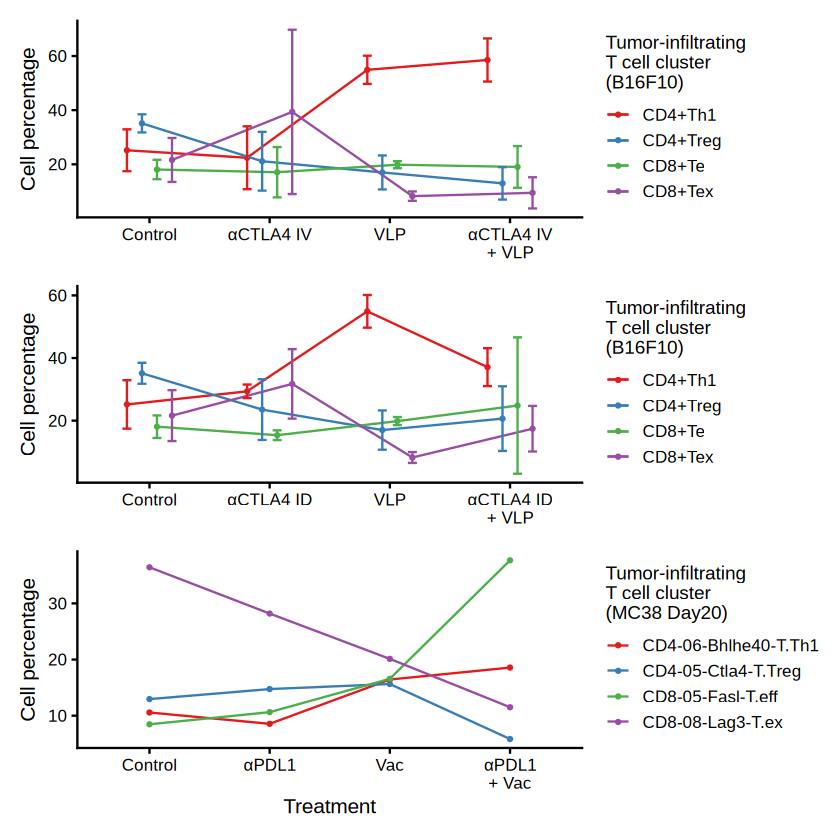

In [18]:
df_prop_b16 <- data.frame(xtabs(~ annotation + orig.ident, 
                                data = merged@meta.data[merged$dataset=='B16F10',])) %>% rename(count=Freq) %>%
    merge(merged@meta.data[merged$dataset=='B16F10',] %>% distinct(treatment, VLP, aCTLA4, orig.ident, batch), by='orig.ident') %>% 
    filter(annotation %in% c('CD4+Treg','CD4+Th1','CD8+Tex','CD8+Te') & aCTLA4 !='ID') %>%
    group_by(orig.ident) %>% 
    mutate(count_sample = sum(count), percentage = count/count_sample*100) %>%
    mutate(treatment=factor(str_replace(treatment,' \\+','\n\\+'), levels=c('Control','αCTLA4 IV','VLP','αCTLA4 IV\n+ VLP'))) %>%
    group_by(treatment, annotation) %>%
    summarize(percentage_mean=mean(percentage), percentage_sd=sd(percentage))
prop_iv_b16 <- ggplot(df_prop_b16, aes(x=treatment, y=percentage_mean, color=annotation, group=annotation)) + 
    geom_point(position=position_dodge(width=.5)) +
    geom_line(position=position_dodge(width=.5)) + 
    geom_errorbar(aes(ymin = percentage_mean - percentage_sd, ymax = percentage_mean + percentage_sd), width = 0.3, position=position_dodge(width=.5)) + 
    theme_cowplot() + theme(axis.title.x=element_blank()) +
    labs(x='Treatment', y='Cell percentage', color='Tumor-infiltrating\nT cell cluster\n(B16F10)')
df_prop_b16 <- data.frame(xtabs(~ annotation + orig.ident, 
                                data = merged@meta.data[merged$dataset=='B16F10',])) %>% rename(count=Freq) %>%
    merge(merged@meta.data[merged$dataset=='B16F10',] %>% distinct(treatment, VLP, aCTLA4, orig.ident, batch), by='orig.ident') %>% 
    filter(annotation %in% c('CD4+Treg','CD4+Th1','CD8+Tex','CD8+Te') & aCTLA4 !='IV') %>%
    group_by(orig.ident) %>% 
    mutate(count_sample = sum(count), percentage = count/count_sample*100) %>%
    mutate(treatment=factor(str_replace(treatment,' \\+','\n\\+'), levels=c('Control','αCTLA4 ID','VLP','αCTLA4 ID\n+ VLP'))) %>%
    group_by(treatment, annotation) %>%
    summarize(percentage_mean=mean(percentage), percentage_sd=sd(percentage))
prop_id_b16 <- ggplot(df_prop_b16, aes(x=treatment, y=percentage_mean, color=annotation, group=annotation)) + 
    geom_point(position=position_dodge(width=.5)) +
    geom_line(position=position_dodge(width=.5)) + 
    geom_errorbar(aes(ymin = percentage_mean - percentage_sd, ymax = percentage_mean + percentage_sd), width = 0.3, position=position_dodge(width=.5)) + 
    theme_cowplot() + theme(axis.title.x=element_blank()) + #
    labs(x='Treatment', y='Cell percentage', color='Tumor-infiltrating\nT cell cluster\n(B16F10)')
df_prop_gse <- data.frame(xtabs(~ clusters + orig.ident, 
                             data = merged@meta.data[merged$orig.ident %in% c('D20TM','D20TM_aPDL1','D20TM_Vac','D20TM_Combo'),])) %>% 
    rename(count=Freq) %>% group_by(orig.ident) %>% 
    mutate(count_sample = sum(count), percentage = count/count_sample*100) %>% 
    filter(clusters %in% c('CD4-05-Ctla4-T.Treg','CD4-06-Bhlhe40-T.Th1','CD8-08-Lag3-T.ex','CD8-05-Fasl-T.eff')) %>%
    mutate(orig.ident=factor(orig.ident, levels=c('D20TM','D20TM_aPDL1','D20TM_Vac','D20TM_Combo')), 
           treatment=recode(orig.ident,'D20TM'='Control','D20TM_aPDL1'='αPDL1','D20TM_Vac'='Vac','D20TM_Combo'='αPDL1\n+ Vac'),
           clusters=factor(clusters, levels=c('CD4-06-Bhlhe40-T.Th1','CD4-05-Ctla4-T.Treg','CD8-05-Fasl-T.eff','CD8-08-Lag3-T.ex')))
prop_gse <- ggplot(df_prop_gse, aes(x=treatment, y=percentage, color=clusters, group=clusters)) + geom_line() + geom_point() + theme_cowplot() +
    labs(x='Treatment', y='Cell percentage', color='Tumor-infiltrating\nT cell cluster\n(MC38 Day20)')
compare1 <- prop_iv_b16 / prop_id_b16 / prop_gse & scale_color_brewer(palette='Set1') & 
    theme(axis.text=element_text(size=10), axis.title=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=11))
compare1
ggsave('plot/compare_proportion.pdf', width=7, height=7, device=cairo_pdf)

# Compare clonal expansion

In [19]:
merged$cloneSize <- factor(merged$cloneSize, levels=c('Hyperexpanded (100 < X <= 1000)',
                                                      'Large (20 < X <= 100)',
                                                      'Medium (5 < X <= 20)',
                                                      'Small (1 < X <= 5)',
                                                      'Single (0 < X <= 1)'                                                  
                                                      ))

DimPlot(merged, group.by = "cloneSize") + 
    scale_color_manual(values=rev(brewer.pal(5, 'YlOrRd')), na.value='grey') + theme_dr() + 
    theme(panel.grid=element_blank(), plot.title = element_blank(),strip.background=element_blank(), legend.position=c(0.37,0.93),  
          strip.text=element_text(face='bold', size=13), legend.text=element_text(size=10)) + 
    guides(color = guide_legend(ncol = 2, override.aes = list(size=2)))

Using Freq as value column: use value.var to override.



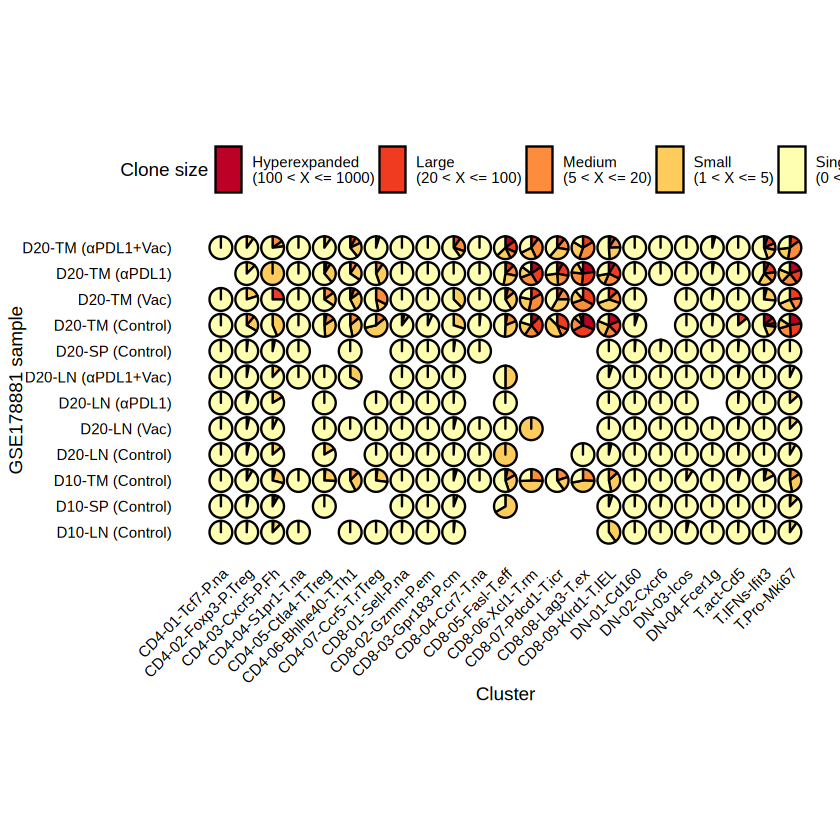

In [20]:
df_clonesize <- data.frame(xtabs(~ clusters + description + cloneSize, data = gse@meta.data)) %>% 
    dcast(clusters+description~cloneSize) %>% #mutate(cloneSize=str_replace(cloneSize, ' \\(','\n\\(')) %>% 
    mutate(int_x=as.integer(clusters), int_y=as.integer(description)) 
ggplot(df_clonesize, aes(y=int_y, x=int_x)) + 
    geom_scatterpie(aes(y=int_y, x=int_x), cols=colnames(df_clonesize)[3:7], data=df_clonesize ) +
    scale_x_continuous(breaks = 1:length(unique(df_clonesize$clusters)), 
                       labels = levels(df_clonesize$clusters), name = "Cluster") +
    scale_y_continuous(breaks = 1:length(unique(df_clonesize$description)), labels = levels(df_clonesize$description), name = "GSE178881 sample") +
    scale_fill_manual(values=rev(brewer.pal(5, 'YlOrRd')), labels=str_replace(colnames(df_clonesize)[3:7], ' \\(','\n\\(')) + 
    coord_equal(clip = 'off') +
    labs(fill='Clone size') + theme_minimal() + 
    theme(axis.text=element_text(color='black'), axis.text.x=element_text(angle=45,hjust=1,vjust=1), 
          panel.grid=element_blank(), legend.key.height = unit(2, 'lines'), legend.position='top')
ggsave('plot/gse178881_clonal_exp_cluster.pdf', width=8, height=7, device=cairo_pdf)

`summarise()` has grouped output by 'sample', 'treatment', 'aCTLA4', 'VLP',
'CDsubset'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample', 'treatment', 'aCTLA4', 'VLP'. You
can override using the `.groups` argument.


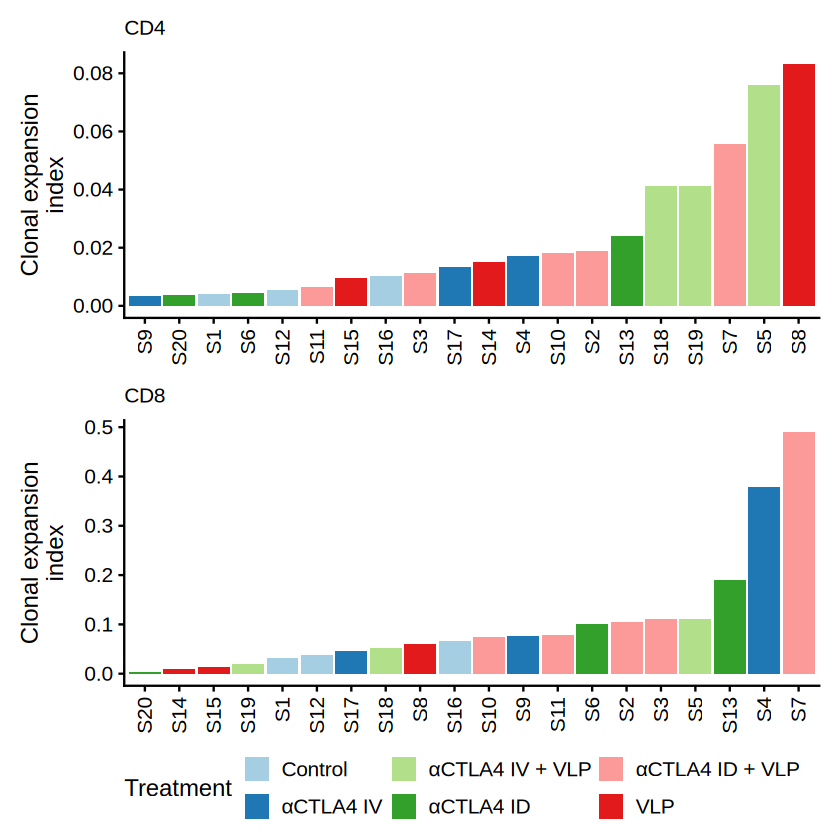

In [21]:
exp_ind_df_b16 <- b16@meta.data %>% filter(!is.na(CTaa)) %>%
    group_by(sample, treatment, aCTLA4, VLP, CDsubset, CTaa, .drop=FALSE) %>% summarise(count=n()) %>%
    group_by(sample, treatment, aCTLA4, VLP, CDsubset, .drop=FALSE) %>% mutate(freq_subset = count/sum(count), n_subset=n()) %>% 
    mutate(even_ind_i = freq_subset*log2(freq_subset)/log2(n_subset)) %>%
    summarise(exp_ind=1+sum(even_ind_i)) %>% filter(CDsubset!='else') %>%
    mutate(VLP=factor(VLP, levels=c('none','ID')), aCTLA4=factor(aCTLA4, levels=c('none','IV', 'ID')), CDsubset=droplevels(CDsubset)) %>% 
    filter(!is.nan(exp_ind))
expansion_cd8_b16 <- ggplot(exp_ind_df_b16 %>% filter(CDsubset=='CD8'), aes(x=sample, y=exp_ind, fill=treatment)) + geom_col() +
    scale_x_discrete(limits=exp_ind_df_b16 %>% filter(CDsubset=='CD8') %>% arrange(exp_ind) %>% pull(sample)) +
    scale_fill_brewer(palette='Paired') +
    theme_cowplot() + labs(y='Clonal expansion\nindex', subtitle='CD8', fill='Treatment') + 
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), axis.title.x=element_blank(), legend.position='bottom')
expansion_cd4_b16 <- ggplot(exp_ind_df_b16 %>% filter(CDsubset=='CD4'), aes(x=sample, y=exp_ind, fill=treatment)) + geom_col() +
    scale_x_discrete(limits=exp_ind_df_b16 %>% filter(CDsubset=='CD4') %>% arrange(exp_ind) %>% pull(sample)) +
    scale_fill_brewer(palette='Paired') +
    theme_cowplot() + labs(y='Clonal expansion\nindex', subtitle='CD4') + 
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), axis.title.x=element_blank(), legend.position='none')
expansion_cd4_b16 / expansion_cd8_b16

`summarise()` has grouped output by 'description', 'CDsubset'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'description'. You can override using the
`.groups` argument.


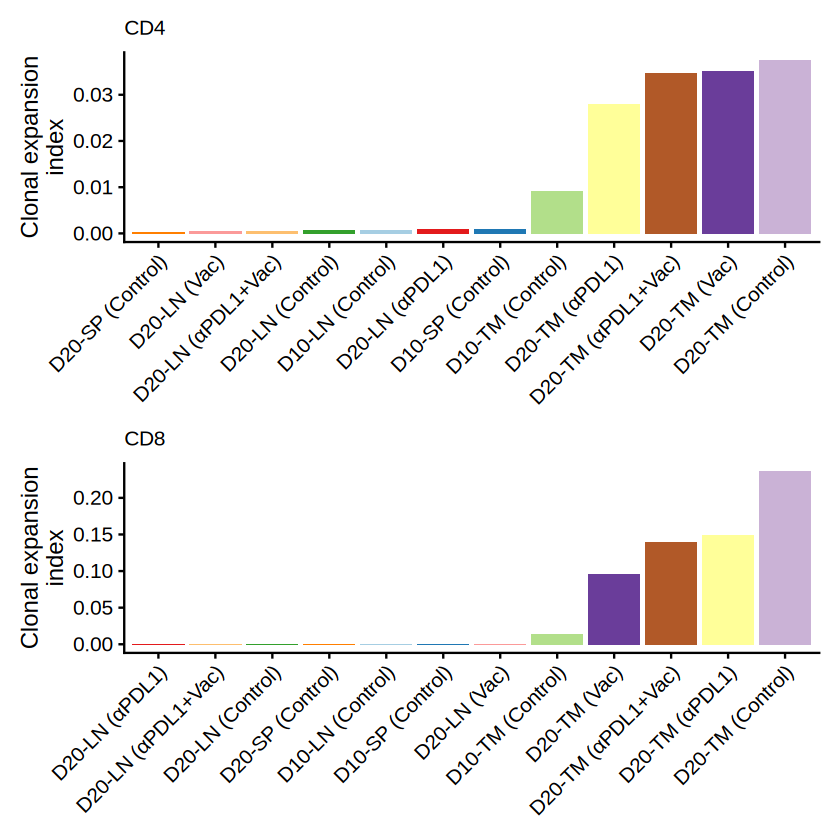

In [22]:
exp_ind_df_gse <- merged@meta.data[merged$dataset=='GSE178881',] %>% filter(!is.na(CTaa)) %>%
    group_by(description, CDsubset, CTaa, .drop=FALSE) %>% summarise(count=n()) %>%
    group_by(description, CDsubset, .drop=FALSE) %>% mutate(freq_subset = count/sum(count), n_subset=n()) %>% 
    mutate(even_ind_i = freq_subset*log2(freq_subset)/log2(n_subset)) %>%
    summarise(exp_ind=1+sum(even_ind_i)) %>% filter(CDsubset!='else') 
expansion_cd8_gse <- ggplot(exp_ind_df_gse %>% filter(CDsubset=='CD8'), aes(x=description, y=exp_ind, fill=description)) + geom_col() +
    scale_x_discrete(limits=exp_ind_df_gse %>% filter(CDsubset=='CD8') %>% arrange(exp_ind) %>% pull(description)) +
    scale_fill_brewer(palette='Paired') +
    theme_cowplot() + labs(y='Clonal expansion\nindex', subtitle='CD8', fill='Treatment') + 
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1), axis.title.x=element_blank(), legend.position='none')
expansion_cd4_gse <- ggplot(exp_ind_df_gse %>% filter(CDsubset=='CD4'), aes(x=description, y=exp_ind, fill=description)) + geom_col() +
    scale_x_discrete(limits=exp_ind_df_gse %>% filter(CDsubset=='CD4') %>% arrange(exp_ind) %>% pull(description)) +
    scale_fill_brewer(palette='Paired') +
    theme_cowplot() + labs(y='Clonal expansion\nindex', subtitle='CD4') + 
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1), axis.title.x=element_blank(), legend.position='none')
expansion_cd4_gse / expansion_cd8_gse 
ggsave('plot/gse178881_clonal_exp_sample.pdf', width=7, height=7, device=cairo_pdf)

`summarise()` has grouped output by 'treatment'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'treatment'. You can override using the
`.groups` argument.


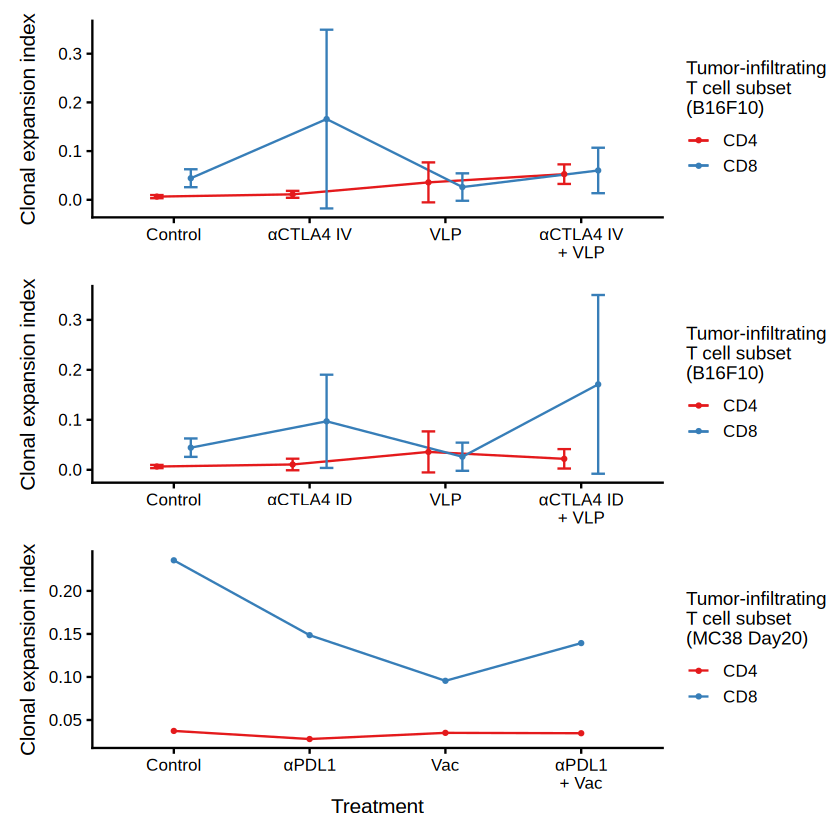

In [23]:
exp_ind_df_b16_id <- exp_ind_df_b16 %>% filter(aCTLA4 !='ID') %>%
    group_by(treatment, CDsubset) %>%
    summarize(ind_mean=mean(exp_ind), ind_sd=sd(exp_ind)) %>% filter(!is.na(ind_mean)) %>%
    mutate(treatment = factor(str_replace(as.character(treatment), ' \\+', '\n\\+'), levels=c('Control','αCTLA4 IV','VLP','αCTLA4 IV\n+ VLP')))
exp_ind_iv_b16 <- ggplot(exp_ind_df_b16_id, aes(x=treatment, y=ind_mean, color=CDsubset, group=CDsubset)) + 
    geom_line(position=position_dodge(width=.5)) + 
    geom_point(position=position_dodge(width=.5)) + 
    geom_errorbar(aes(ymin = ind_mean - ind_sd, ymax = ind_mean + ind_sd), width = 0.2, position=position_dodge(width=.5)) +
    theme_cowplot() + theme(axis.title.x=element_blank()) +
    labs(x='Treatment', y='Clonal expansion index', color='Tumor-infiltrating\nT cell subset\n(B16F10)')
exp_ind_df_b16_iv <- exp_ind_df_b16 %>% filter(aCTLA4 !='IV') %>%
    group_by(treatment, CDsubset) %>%
    summarize(ind_mean=mean(exp_ind), ind_sd=sd(exp_ind))  %>% filter(!is.na(ind_mean)) %>%
    mutate(treatment = factor(str_replace(as.character(treatment), ' \\+', '\n\\+'), levels=c('Control','αCTLA4 ID','VLP','αCTLA4 ID\n+ VLP')))
exp_ind_id_b16 <- ggplot(exp_ind_df_b16_iv, aes(x=treatment, y=ind_mean, color=CDsubset, group=CDsubset)) + 
    geom_line(position=position_dodge(width=.5)) + 
    geom_point(position=position_dodge(width=.5)) + 
    geom_errorbar(aes(ymin = ind_mean - ind_sd, ymax = ind_mean + ind_sd), width = 0.2, position=position_dodge(width=.5)) +
    theme_cowplot() + theme(axis.title.x=element_blank()) +
    labs(x='Treatment', y='Clonal expansion index', color='Tumor-infiltrating\nT cell subset\n(B16F10)')
exp_ind_df_gse_d20 <- exp_ind_df_gse %>% filter(description %in% c('D20-TM (Control)','D20-TM (αPDL1)','D20-TM (Vac)','D20-TM (αPDL1+Vac)')) %>%
                      mutate(treatment=factor(recode(description,'D20-TM (Control)'='Control','D20-TM (αPDL1)'='αPDL1',
                                                     'D20-TM (Vac)'='Vac','D20-TM (αPDL1+Vac)'='αPDL1\n+ Vac'), 
                                              levels=c('Control','αPDL1','Vac','αPDL1\n+ Vac')))
exp_ind_gse <- ggplot(exp_ind_df_gse_d20, aes(x=treatment, y=exp_ind, color=CDsubset, group=CDsubset)) + geom_line() + geom_point() + theme_cowplot() +
    labs(x='Treatment', y='Clonal expansion index', color='Tumor-infiltrating\nT cell subset\n(MC38 Day20)')
compare2 <- exp_ind_iv_b16 / exp_ind_id_b16 / exp_ind_gse & scale_color_brewer(palette='Set1') & 
    theme(axis.text=element_text(size=10), axis.title=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=11))
compare2 
ggsave('plot/compare_clonal_expansion.pdf', width=7, height=7, device=cairo_pdf)

# Compare vaccine peptide specificity

`summarise()` has grouped output by 'description'. You can override using the
`.groups` argument.


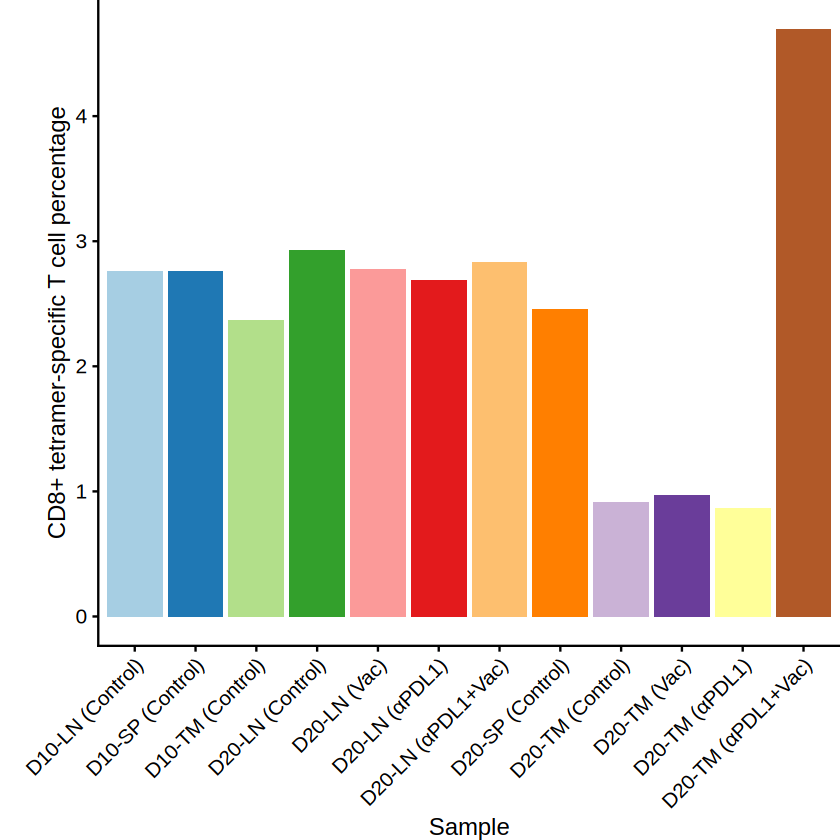

In [24]:
df_gse_specific <- merged@meta.data %>% filter(dataset=='GSE178881' & CDsubset=='CD8') %>% 
    group_by(description, tetramer.) %>% summarize(count=n()) %>% 
    group_by(description) %>% mutate(pct_sample=count/sum(count)*100) %>% filter(tetramer.==TRUE)
ggplot(df_gse_specific, aes(x=description, y=pct_sample, fill=description)) + geom_col() + theme_cowplot() +
    scale_fill_brewer(palette='Paired') + labs(x='Sample', y='CD8+ tetramer-specific T cell percentage') +
    theme(legend.position='none', axis.text.x=element_text(angle=45, hjust=1, vjust=1), plot.margin=unit(c(0,0,0,0.4),"in"))
ggsave('plot/gse178881_bar_antigen_specific_by_sample.pdf', width=6, height=4, device=cairo_pdf)

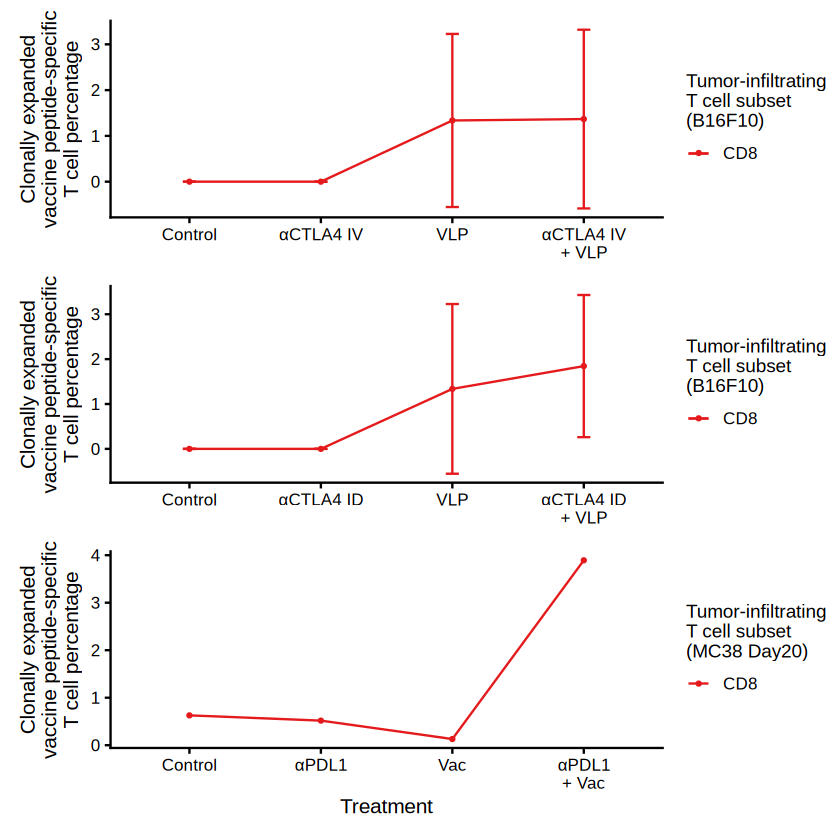

In [25]:
specific_df_gse_d20 <-merged@meta.data %>% filter(dataset=='GSE178881' & (CDsubset=='CD8' | clusters == 'T.Pro-Mki67') & !is.na(clonalFrequency)) %>% 
    group_by(sample) %>% summarize(pct=mean(clonalFrequency>1 & tetramer.)*100) %>% 
    filter(sample %in% c('D20TM','D20TM_aPDL1','D20TM_Vac','D20TM_Combo')) %>% 
                      mutate(treatment=factor(recode(sample,'D20TM'='Control','D20TM_aPDL1'='αPDL1','D20TM_Vac'='Vac','D20TM_Combo'='αPDL1\n+ Vac'), 
                                              levels=c('Control','αPDL1','Vac','αPDL1\n+ Vac')))
specific_gse <- ggplot(specific_df_gse_d20, aes(x=treatment, y=pct, group=1, color='CD8')) + geom_line() + geom_point() + theme_cowplot() +
    labs(x='Treatment', y='Clonally expanded\nvaccine peptide-specific\nT cell percentage', color='Tumor-infiltrating\nT cell subset\n(MC38 Day20)')
specific_df_cd8 <- read.csv('csv/specific_percentage_sample_cd8.csv') %>% 
    mutate(specific_pct=100*specific_ratio, treatment=treatment %>% str_replace(' \\+','\n\\+')) 
specific_df_b16_iv <- specific_df_cd8 %>% filter(treatment %in% c('Control','αCTLA4 IV','VLP','αCTLA4 IV\n+ VLP')) %>%
    group_by(treatment) %>%
    summarize(ind_mean=mean(specific_pct), ind_sd=sd(specific_pct)) %>%
    mutate(treatment=factor(treatment, levels=c('Control','αCTLA4 IV','VLP','αCTLA4 IV\n+ VLP')))
specific_b16_iv <- ggplot(specific_df_b16_iv, aes(x=treatment, y=ind_mean, group=1, color='CD8')) + 
    geom_line(position=position_dodge(width=.5)) + 
    geom_point(position=position_dodge(width=.5)) + 
    geom_errorbar(aes(ymin = ind_mean - ind_sd, ymax = ind_mean + ind_sd), width = 0.1, position=position_dodge(width=.5)) +
    theme_cowplot() + theme(axis.title.x=element_blank()) +
    labs(x='Treatment', y='Clonally expanded\nvaccine peptide-specific\nT cell percentage', color='Tumor-infiltrating\nT cell subset\n(B16F10)')
specific_df_b16_id <- specific_df_cd8 %>% filter(treatment %in% c('Control','αCTLA4 ID','VLP','αCTLA4 ID\n+ VLP')) %>%
    group_by(treatment) %>%
    summarize(ind_mean=mean(specific_pct), ind_sd=sd(specific_pct)) %>%
    mutate(treatment=factor(treatment, levels=c('Control','αCTLA4 ID','VLP','αCTLA4 ID\n+ VLP')))
specific_b16_id <- ggplot(specific_df_b16_id, aes(x=treatment, y=ind_mean, group=1, color='CD8')) + 
    geom_line(position=position_dodge(width=.5)) + 
    geom_point(position=position_dodge(width=.5)) + 
    geom_errorbar(aes(ymin = ind_mean - ind_sd, ymax = ind_mean + ind_sd), width = 0.1, position=position_dodge(width=.5)) +
    theme_cowplot() + theme(axis.title.x=element_blank()) +
    labs(x='Treatment', y='Clonally expanded\nvaccine peptide-specific\nT cell percentage', color='Tumor-infiltrating\nT cell subset\n(B16F10)')
compare3 <- specific_b16_iv / specific_b16_id / specific_gse & scale_color_brewer(palette='Set1') & 
    theme(axis.text=element_text(size=10), axis.title=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=11))
compare3 
ggsave('plot/compare_antigen_specificity.pdf', width=7, height=7, device=cairo_pdf)

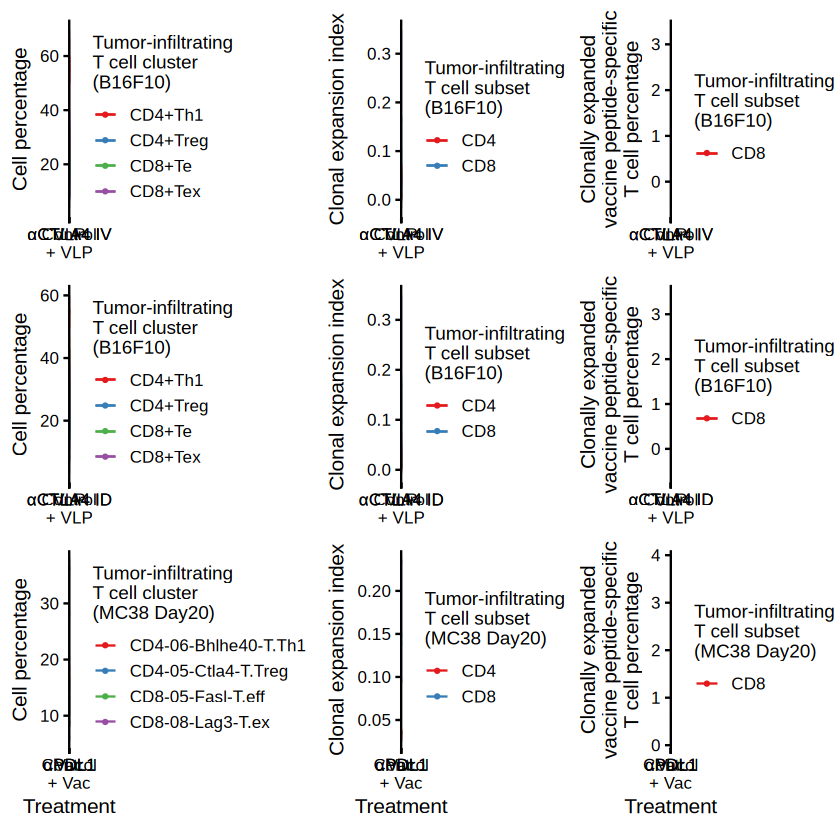

In [26]:
compare1 | compare2 | compare3 
ggsave('plot/compare_between_datasets.pdf', width=16, height=7, device=cairo_pdf)

`summarise()` has grouped output by 'clusters'. You can override using the
`.groups` argument.


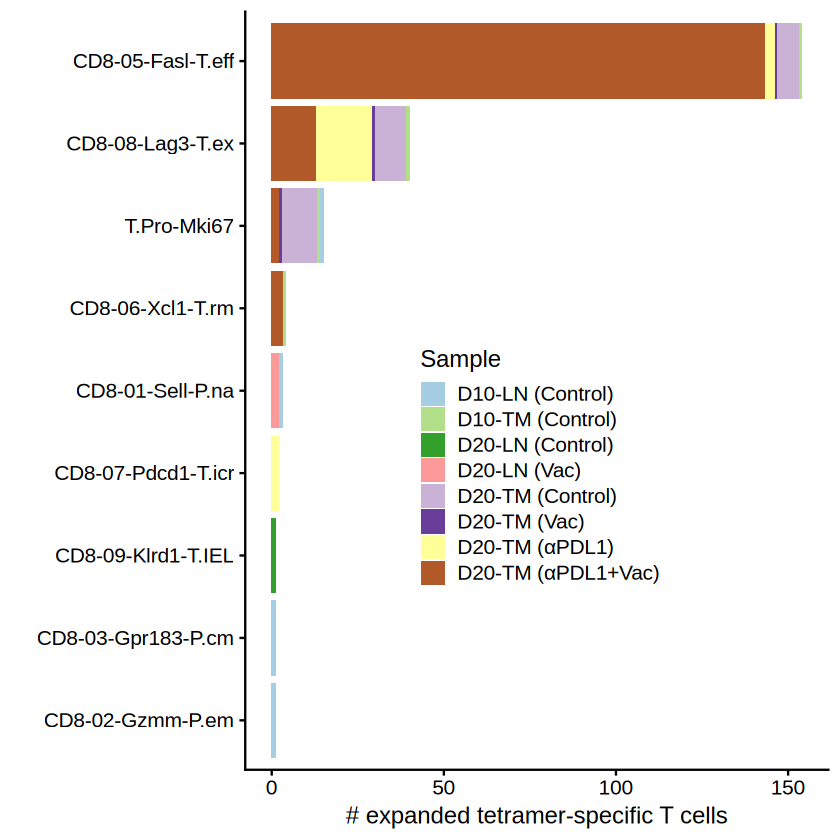

In [27]:
specific_by_cluster <- merged@meta.data %>% filter(dataset=='GSE178881' & clonalFrequency>1 & (CDsubset=='CD8' | clusters == 'T.Pro-Mki67')) %>% 
        group_by(clusters, description) %>% summarize(count=sum(tetramer.)) %>% filter(count>0)  %>% arrange(count)
ggplot(specific_by_cluster, aes(y=clusters, x=count, fill=description)) + 
    geom_col() + theme_cowplot() + labs(x='# expanded tetramer-specific T cells', y='', fill='Sample') + 
    scale_y_discrete(limits=specific_by_cluster %>% group_by(clusters) %>% summarize(total=sum(count)) %>% arrange(total) %>% pull(clusters)) + 
    theme(legend.position=c(0.3,0.4)) + scale_fill_manual(values=brewer.pal(12,'Paired')[c(1,3,4,5,9:12)])
ggsave('plot/gse178881_bar_antigen_specific_by_annotation.pdf', width=5, height=4, device=cairo_pdf)